In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-prediction/heart.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings("ignore")

# *Read Data*

In [3]:
df=pd.read_csv("/kaggle/input/heart-failure-prediction/heart.csv")
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [6]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [7]:
df.duplicated().sum()

0

# *Encoding*

In [8]:
le1 = preprocessing.LabelEncoder()
df['Sex'] =le1.fit_transform(df['Sex'])
le2 = preprocessing.LabelEncoder()
df['ChestPainType'] =le2.fit_transform(df['ChestPainType'])
le3 = preprocessing.LabelEncoder()
df['RestingECG'] =le2.fit_transform(df['RestingECG'])
le4 = preprocessing.LabelEncoder()
df['ExerciseAngina'] =le2.fit_transform(df['ExerciseAngina'])
le5 = preprocessing.LabelEncoder()
df['ST_Slope'] =le2.fit_transform(df['ST_Slope'])

# *Select columns*

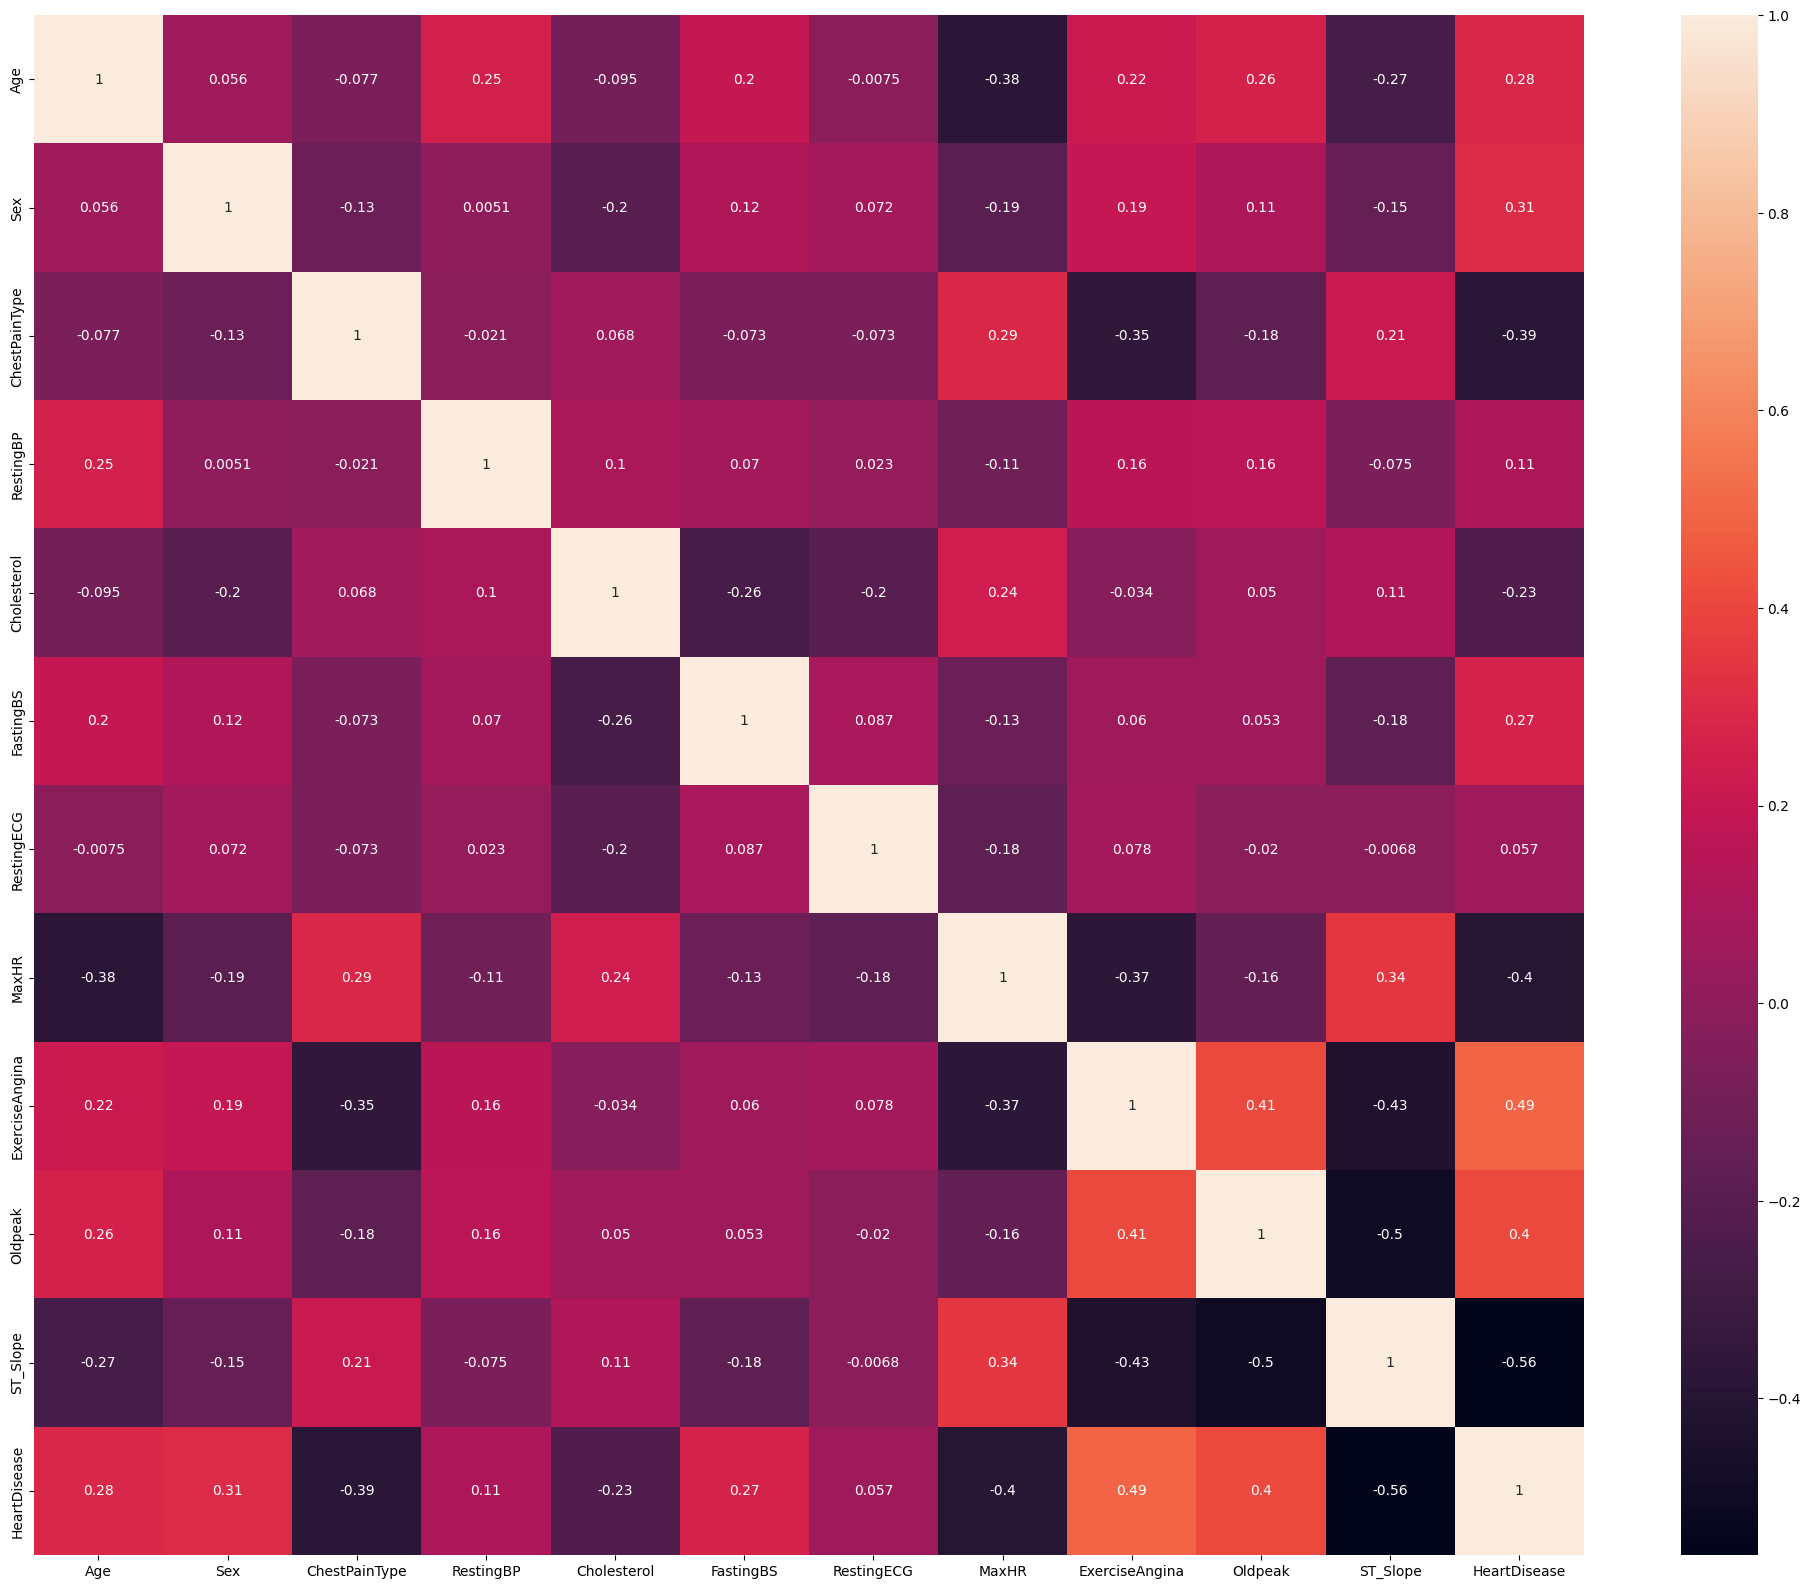

In [9]:
numerical_data = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numerical_data.corr()
plt.figure(figsize=(25, 20))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [10]:
threshold=0.2
correlation_matrix=df.corr()
high_corr_features=correlation_matrix.index[abs(correlation_matrix["HeartDisease"])>threshold].tolist()
high_corr_features.remove("HeartDisease")
print("Selected features based on correlation with target:")
print(high_corr_features)
X_selected=df[high_corr_features]
y=df["HeartDisease"]

Selected features based on correlation with target:
['Age', 'Sex', 'ChestPainType', 'Cholesterol', 'FastingBS', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']


# *Detect&Remove outliers from selected columns*

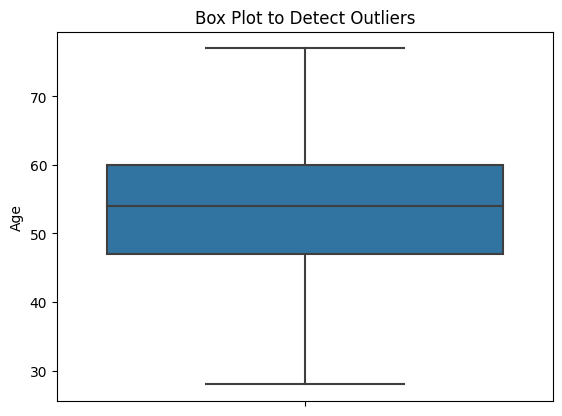

<Figure size 1200x600 with 0 Axes>

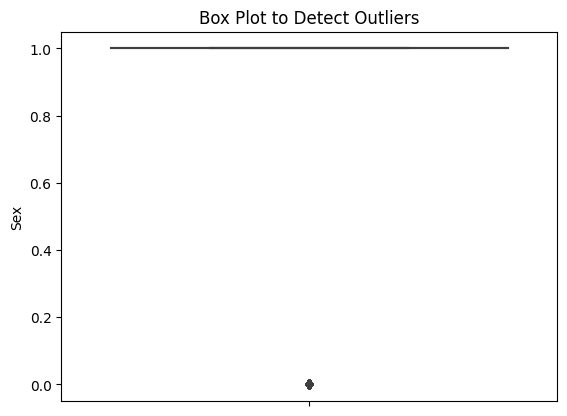

<Figure size 1200x600 with 0 Axes>

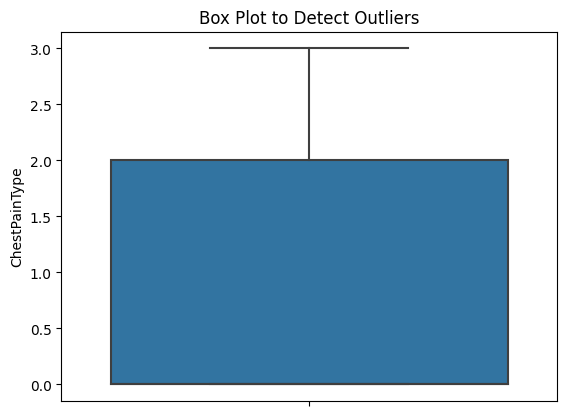

<Figure size 1200x600 with 0 Axes>

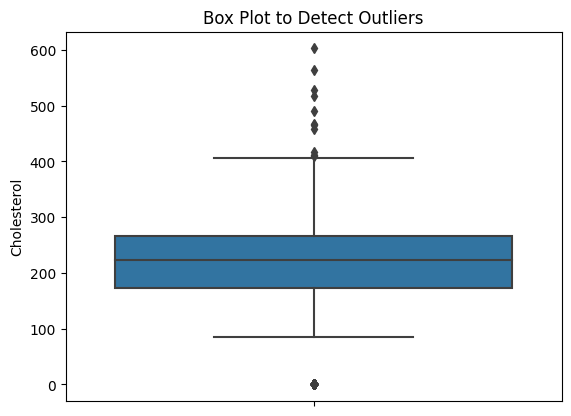

<Figure size 1200x600 with 0 Axes>

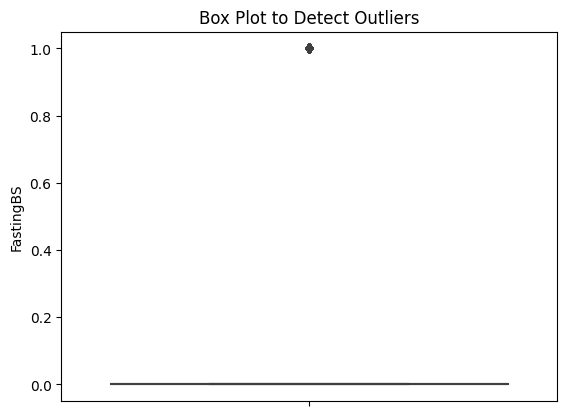

<Figure size 1200x600 with 0 Axes>

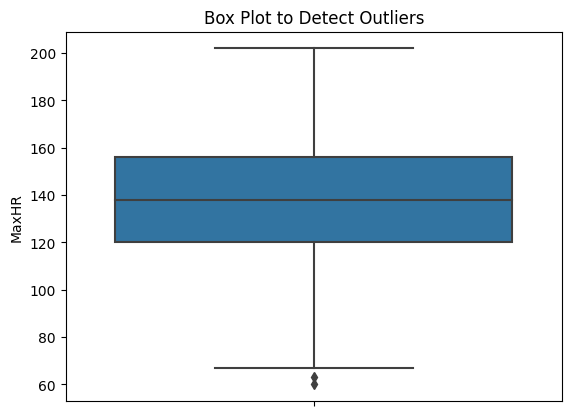

<Figure size 1200x600 with 0 Axes>

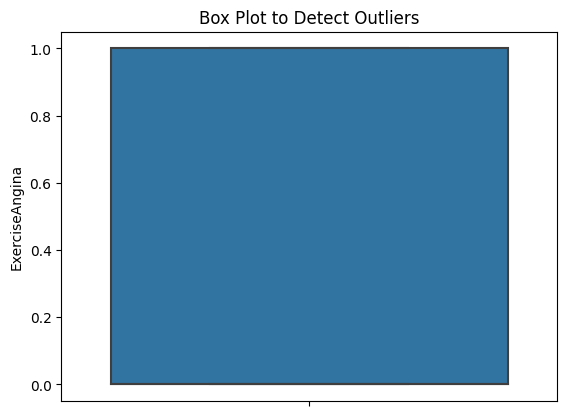

<Figure size 1200x600 with 0 Axes>

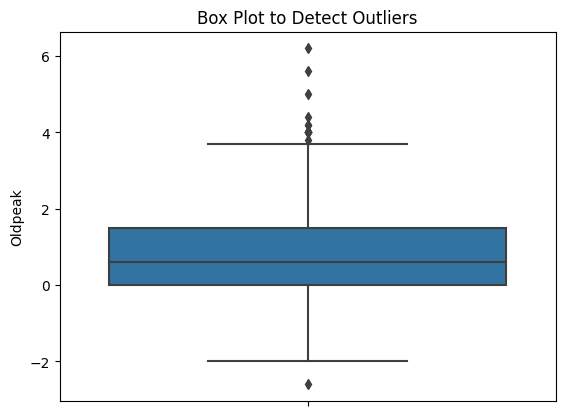

<Figure size 1200x600 with 0 Axes>

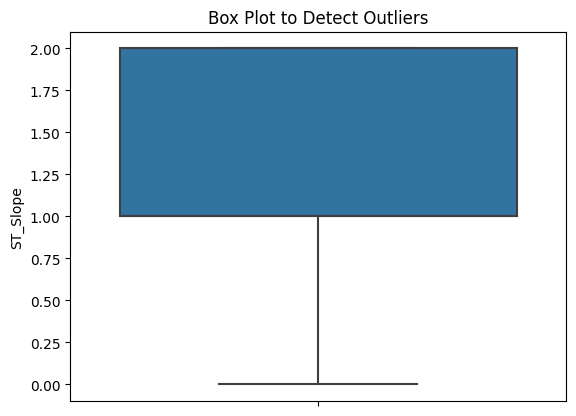

<Figure size 1200x600 with 0 Axes>

In [11]:
for column in X_selected:
    sns.boxplot(y=column, data=df)
    plt.title("Box Plot to Detect Outliers")
    plt.figure(figsize=(12, 6))
    plt.show()

In [12]:
for i in df:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3-Q1
    min = Q1 - 1.5* IQR
    MAX = Q3 + 1.5* IQR
    df[i] = np.where(df[i] < min, min, df[i])
    df[i] = np.where(df[i] > MAX, MAX, df[i])

# *Data Scalling*

In [13]:
scaler = MinMaxScaler()
x=scaler.fit_transform(X_selected)

# *Spilitting Data*

In [14]:
X_train, X_test, Y_train, Y_test= train_test_split(x,y, test_size=0.3, shuffle = True, random_state=42)

In [15]:
X_train.shape

(642, 9)

# *Logistic Regression*

In [16]:
lo_model = LogisticRegression()
lo_model.fit(X_train, Y_train)

LogisticRegression()

In [17]:
lo_model.score(X_train, Y_train)

0.8520249221183801

In [18]:
Y_pred_lo = lo_model.predict(X_test)

In [19]:
print(accuracy_score(Y_pred_lo, Y_test))

0.8695652173913043


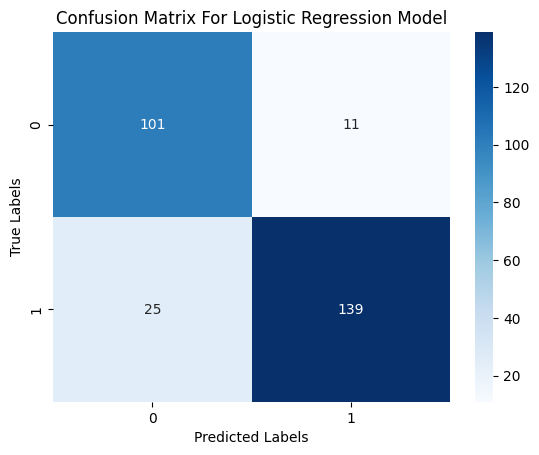

In [20]:
cm_lo = confusion_matrix(Y_test, Y_pred_lo)
sns.heatmap(cm_lo, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1' ])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For Logistic Regression Model')
plt.show()

In [21]:
print(classification_report(Y_pred_lo, Y_test))

              precision    recall  f1-score   support

           0       0.90      0.80      0.85       126
           1       0.85      0.93      0.89       150

    accuracy                           0.87       276
   macro avg       0.87      0.86      0.87       276
weighted avg       0.87      0.87      0.87       276



# *SVM*

In [22]:
svc_model=SVC()
svc_model.fit(X_train,Y_train)

SVC()

In [23]:
svc_model.score(X_train,Y_train)

0.8644859813084113

In [24]:
Y_pred_svc=svc_model.predict(X_test)

In [25]:
print(accuracy_score(Y_pred_svc, Y_test))

0.8623188405797102


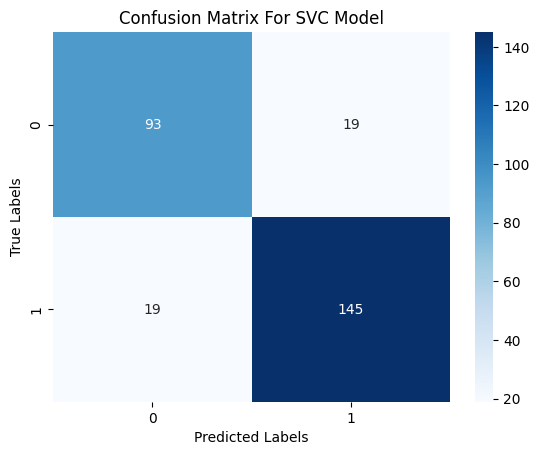

In [26]:
cm_svc = confusion_matrix(Y_test, Y_pred_svc)
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1' ])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For SVC Model')
plt.show()

In [27]:
print(classification_report(Y_pred_svc, Y_test))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       112
           1       0.88      0.88      0.88       164

    accuracy                           0.86       276
   macro avg       0.86      0.86      0.86       276
weighted avg       0.86      0.86      0.86       276



# *KNN*

In [28]:
knn_model=KNeighborsClassifier()
knn_model.fit(X_train,Y_train)

KNeighborsClassifier()

In [29]:
Y_pred_knn=knn_model.predict(X_test)

In [30]:
print(accuracy_score(Y_pred_knn, Y_test))

0.8514492753623188


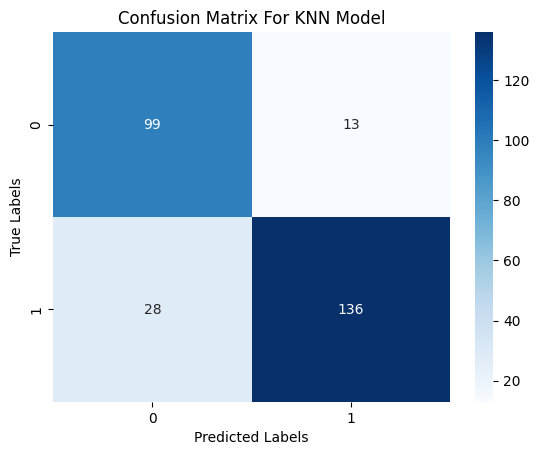

In [31]:
cm_knn = confusion_matrix(Y_test, Y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1' ])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For KNN Model')
plt.show()

In [32]:
print(classification_report(Y_pred_knn, Y_test))

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       127
           1       0.83      0.91      0.87       149

    accuracy                           0.85       276
   macro avg       0.86      0.85      0.85       276
weighted avg       0.85      0.85      0.85       276



# *Naive Bayes*

In [33]:
gnb_model=GaussianNB()
gnb_model.fit(X_train,Y_train)

GaussianNB()

In [34]:
Y_pred_gnb=gnb_model.predict(X_test)

In [35]:
print(accuracy_score(Y_pred_gnb, Y_test))

0.8731884057971014


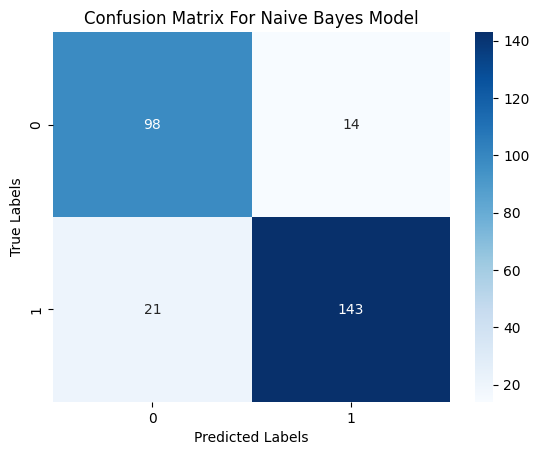

In [36]:
cm_gnb = confusion_matrix(Y_test, Y_pred_gnb)
sns.heatmap(cm_gnb, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1' ])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For Naive Bayes Model')
plt.show()

In [37]:
print(classification_report(Y_pred_gnb, Y_test))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85       119
           1       0.87      0.91      0.89       157

    accuracy                           0.87       276
   macro avg       0.87      0.87      0.87       276
weighted avg       0.87      0.87      0.87       276



# *Decision Tree*

In [38]:
dt_model=DecisionTreeClassifier()
dt_model.fit(X_train,Y_train)

DecisionTreeClassifier()

In [39]:
Y_pred_dt=dt_model.predict(X_test)

In [40]:
print(accuracy_score(Y_pred_dt, Y_test))

0.7536231884057971


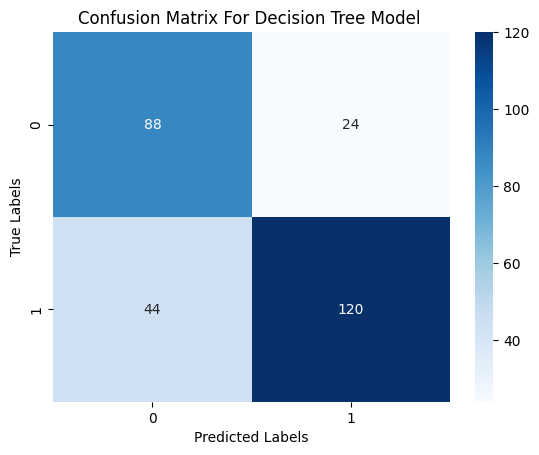

In [41]:
cm_dt = confusion_matrix(Y_test, Y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1' ])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For Decision Tree Model ')
plt.show()

In [42]:
print(classification_report(Y_pred_dt, Y_test))

              precision    recall  f1-score   support

           0       0.79      0.67      0.72       132
           1       0.73      0.83      0.78       144

    accuracy                           0.75       276
   macro avg       0.76      0.75      0.75       276
weighted avg       0.76      0.75      0.75       276



# *Random Forest*

In [43]:
rf_model=RandomForestClassifier()
rf_model.fit(X_train,Y_train)

RandomForestClassifier()

In [44]:
Y_pred_rf=rf_model.predict(X_test)

In [45]:
print(accuracy_score(Y_pred_rf, Y_test))

0.8731884057971014


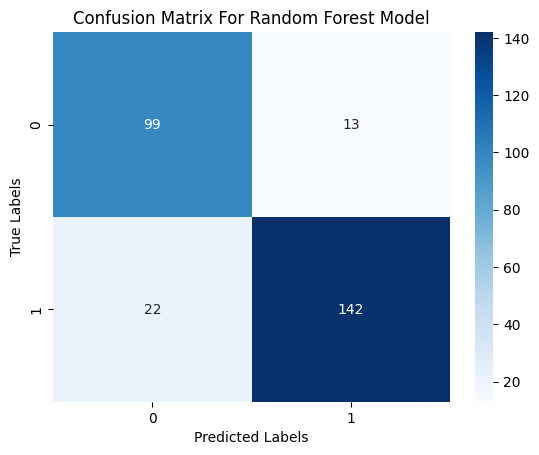

In [46]:
cm_rf = confusion_matrix(Y_test, Y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1' ])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For Random Forest Model')
plt.show()

In [47]:
print(classification_report(Y_pred_rf, Y_test))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85       121
           1       0.87      0.92      0.89       155

    accuracy                           0.87       276
   macro avg       0.87      0.87      0.87       276
weighted avg       0.87      0.87      0.87       276



# *XGBoost*

In [48]:
xgb_model=XGBClassifier()
xgb_model.fit(X_train,Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [49]:
Y_pred_xgb=xgb_model.predict(X_test)

In [50]:
print(accuracy_score(Y_pred_xgb, Y_test))

0.8478260869565217


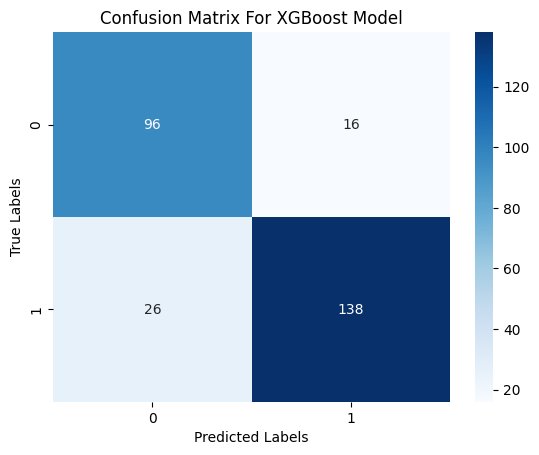

In [51]:
cm_xgb = confusion_matrix(Y_test, Y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1' ])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For XGBoost Model')
plt.show()

In [52]:
print(classification_report(Y_pred_xgb, Y_test))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82       122
           1       0.84      0.90      0.87       154

    accuracy                           0.85       276
   macro avg       0.85      0.84      0.84       276
weighted avg       0.85      0.85      0.85       276

